# KNN model


### 1a. Import dependencies for data manipulation and visualization

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#### Import data

In [22]:
df = pd.read_pickle('../../data/ava_st1_ns4_56.pkl')
df.head


<bound method NDFrame.head of        apcp_sf1_1  apcp_sf2_1 apcp_sf3_1  apcp_sf4_1  apcp_sf5_1  dlwrf_s1_1  \
V1       0.000000         0.0          1    0.000000    0.000000  256.492673   
V2       0.000000         0.0          1    0.017273    0.139091  257.998596   
V3       0.000000         0.0          1    0.000000    0.000000  219.280002   
V4       0.004545         0.0          1    0.000000    0.000000  267.863045   
V5       0.000000         0.0          1    0.000000    0.000000  238.162747   
...           ...         ...        ...         ...         ...         ...   
V4376    0.010909         0.0          1    0.000000    0.000000  278.168651   
V4377    0.000000         0.0          1    0.000000    0.000000  251.551092   
V4378    0.000000         0.0          1    0.000000    0.000000  269.446164   
V4379    0.000000         0.0          1    0.000000    0.000000  268.862049   
V4380    0.000000         0.0          1    0.000000    0.000000  269.112621   

       dl

#### Establish inputs and output columns.

In [23]:
x = df.drop('energy', axis=1)
y = df['energy']


### Now I want to look at the data and do some cleanup if we have any outliers that might skew evaluation of the model.

mean:  16872466.03287671
median:  16957050.0


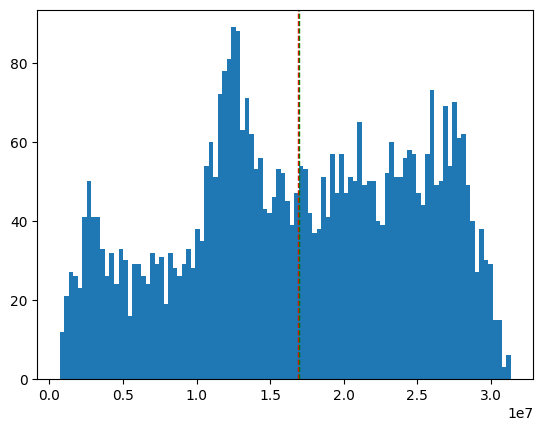

In [24]:
# plot the y values to see the distribution and check for outliers

plt.hist(y, bins=100)

plt.axvline(y.mean(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(y.median(), color='g', linestyle='dashed', linewidth=1)

print('mean: ', y.mean())
print('median: ', y.median())

plt.show()

As we can see in the histogram, our data appears to bi-modal. This will impact which evaluation model we use because we will need to make sure that error measurements are not skewed by the bi-modal distribution.

In [25]:

# Even though the distribution is skewed, there don't appear to be any outliers, but let's check anyway

# Identify the outliers using the IQR method

q1 = y.quantile(0.25)
q3 = y.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5*iqr)
upper_bound = q3 + (1.5*iqr)

# Identify the number of outliers

print('number of outliers: ', len(y[y > upper_bound]) + len(y[y < lower_bound]))

number of outliers:  0


##### Since the number of outliers is 0, we can proceed with the model.
However, we will have to consider the skewness of the data when we evaluate the model.

#### Import sklearn dependencies for standardization and train/test split.

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


#### Standardize the data and scale it for easier processing.

In [27]:
preprocessor = ColumnTransformer(
    transformers = [
        ('STscaler', StandardScaler(), make_column_selector(dtype_include=np.float64)),
        ('MMscaler', MinMaxScaler(), make_column_selector(dtype_include=np.int64))
    ],
    remainder = 'passthrough'
)

preprocessor.fit(x)

X =  preprocessor.transform(x)



# Now do Holdout Method
#### We will use holdout at first to get a baseline accuracy score and show improvements with cross validation and hyperparameter tuning.

Split the data into training and testing sets.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


Import model from sci-kit learn and fit the data and then predict the output.

In [29]:
from sklearn.neighbors import KNeighborsRegressor

In [30]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [31]:
y_pred = knn.predict(X_test)

#### Creating a Dummy regressor to see if the model is better than a trivial model.

In [32]:
from sklearn.dummy import DummyRegressor

In [33]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)

### Import dependencies for evaluation metrics and calculate mean squared error, r2 score, mean absolute error.

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

my_scores = []


In [35]:
mse_values = ["MSE"]
mse = mean_squared_error(y_test, y_pred)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
print("The model's mse: ", mse)
print("The dummy's mse: ", mse_dummy)
print("Relative error: ", mse/mse_dummy)

mse_values.append(mse)
mse_values.append(mse_dummy)

my_scores.append(mse_values)




The model's mse:  13520397207887.014
The dummy's mse:  63532447002696.09
Relative error:  0.21281089971732484


In [36]:
r2_values = ["R2"]
r2 = r2_score(y_test, y_pred)
r2_dummy = r2_score(y_test, y_pred_dummy)
print("The model's r2: ", r2)   
print("The dummy's r2: ", r2_dummy)

r2_values.append(r2)
r2_values.append(r2_dummy)

my_scores.append(r2_values)


The model's r2:  0.7868944825864487
The dummy's r2:  -0.0013844107450222687


In [37]:
mae_values = ["MAE"]
mae = mean_absolute_error(y_test, y_pred)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
print("The model's mae: ", mae)
print("The dummy's mae: ", mae_dummy)
print("Relative error: ", mae/mae_dummy)

mae_values.append(mae)
mae_values.append(mae_dummy)

my_scores.append(mae_values)

The model's mae:  2566933.515981735
The dummy's mae:  6780693.274074247
Relative error:  0.37856505407733443


#### Now I want to visualize these scores and determine how we'll compare it to other more sophisticated models.

In [38]:
print(f"{'Evaluation method':<25} {'Score':<20} {'Dummy Score':<20} {'Ratio (Score/Dummy Score)':<20}")

for item in my_scores:
    ratio = item[1]/item[2] if item[2] != 0 else 0
    print(f"{item[0]:<25} {item[1]:<20.3f} {item[2]:<20.3f} {ratio:<10.3f}")
    
    # print the ratio of the mse score over the mean value of y_test
print(f"Ratio of mae over mean value of y: {(mae)/np.mean(y):.3f}")
    
 



Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       13520397207887.014   63532447002696.094   0.213     
R2                        0.787                -0.001               -568.397  
MAE                       2566933.516          6780693.274          0.379     
Ratio of mae over mean value of y: 0.152


Given the bi-modal distribution of the data, we will need to consider the mean absolute error as the primary evaluation metric.


#### Let's also look at the residuals to see if there are any patterns.

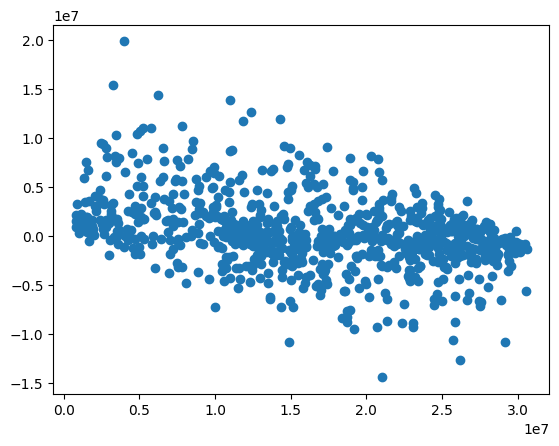

In [39]:
plt.scatter(y_test, y_pred - y_test)
# plt.scatter(y_test, y_pred_dummy - y_test)
plt.show()

We can see that the residuals are slightly homoscedastic, but there is a slight decreasing trend. This is likely due to the bi-modal distribution of the data.

# That was the Holdout Method, now do K-Fold Cross Validation

## Pt.2 Hyper parameter tuning with cross validation

In [40]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score

# Define the cross validation scheme.
cv = KFold(n_splits=5, shuffle=True, random_state=56)


scores = cross_val_score(knn, X, y, cv=cv, scoring='neg_mean_absolute_error')
print(scores)
print(f"{'Average MAE scores without HPO: '}", -scores.mean())
print(f"{'Average MAE scores without HPO as a percentage of the mean y value: '}", f"{(-scores.mean()/np.mean(y)*100):.2f}", '%')


# Define the search space

param_grid = {
    'n_neighbors': list(range(1, 50)),
}


# TODO - think about iterating over the grid and storing results to be able to plot the results. Have to put after fit func.
# print( pd.DataFrame(better_knn.cv_results_)[['mean_test_score', 'std_test_score', 'params']].sort_values(by='mean_test_score', ascending=False).head(5) )


better_knn = GridSearchCV(knn, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_error', refit=True)

#get the scores from the cross validation with HPO


better_knn.fit(X_train, y_train) 
better_scores = cross_val_score(better_knn, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

print(f"{'Scores from CV with HPO'}", better_scores)
print(f"{'Average MAE scores with HPO: '}", -better_scores.mean())
print(f"{'Average MAE scores with HPO as a percentage of the mean y value: '}", f"{(-better_scores.mean()/np.mean(y)*100):.2f}", '%')



print(f"{'The best number of neighbors when using negative mean absolute error scoring is: '}", better_knn.best_params_)
print(f"{'The best MAE score attained was: '}", -better_knn.best_score_)

print(f"{'HPO leads to a '}", f"{(1-(-better_scores.mean()/np.mean(y))/(-scores.mean()/np.mean(y)))*100:.2f}", '%', " improvement in MAE score over the model without HPO")


[-2510567.60730594 -2518105.26484018 -2412715.         -2413968.48858447
 -2513546.93150685]
Average MAE scores without HPO:  2473780.658447488
Average MAE scores without HPO as a percentage of the mean y value:  14.66 %


Scores from CV with HPO [-2365383.92011412 -2409017.32226689 -2214269.01141227 -2370242.57974322
 -2367052.47428571]
Average MAE scores with HPO:  2345193.061564444
Average MAE scores with HPO as a percentage of the mean y value:  13.90 %
The best number of neighbors when using negative mean absolute error scoring is:  {'n_neighbors': 8}
The best MAE score attained was:  2334366.873206644
HPO leads to a  5.20 %  improvement in MAE score over the model without HPO


From these results it appears that the optimal number of neighbors is 14. Using this new tuned model, we can now evaluate the model using the holdout method and our original test data.

### Now let's use this new model to predict values of the test data and evaluate the model.

In [67]:
better_predictions = better_knn.predict(X_test)


my_scores = []


mse_values = ["MSE"]
mse = mean_squared_error(y_test, better_predictions)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)

mse_values.append(mse)
mse_values.append(mse_dummy)

my_scores.append(mse_values)



r2_values = ["R2"]
r2 = r2_score(y_test, better_predictions)
r2_dummy = r2_score(y_test, y_pred_dummy)

r2_values.append(r2)
r2_values.append(r2_dummy)

my_scores.append(r2_values)



mae_values = ["MAE"]
mae = mean_absolute_error(y_test, better_predictions)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)

mae_values.append(mae)
mae_values.append(mae_dummy)

my_scores.append(mae_values)


print(f"{'Evaluation method':<25} {'Score':<20} {'Dummy Score':<20} {'Ratio (Score/Dummy Score)':<20}")

for item in my_scores:
    ratio = item[1]/item[2] if item[2] != 0 else 0
    print(f"{item[0]:<25} {item[1]:<20.3f} {item[2]:<20.3f} {ratio:<10.3f}")
    
    # print the ratio of the mse score over the mean value of y_test
print(f"Ratio of mae over mean value of y: {(mae)/np.mean(y):.3f}")



Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       11235588687644.688   68355363406759.742   0.164     
R2                        0.836                -0.000               -17763.267
MAE                       2359698.895          7104982.821          0.332     
Ratio of mae over mean value of y: 0.140


In [42]:
import matplotlib.pyplot as plt

prediction_scores = {}
n_neighbors = np.arange(2, 60, 1)

for neighbors in n_neighbors:
    knn = KNeighborsRegressor(n_neighbors=neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    prediction_scores[neighbors] = mean_absolute_error(y_test, y_pred)/mae_dummy
    

Plot the scores

In [ ]:
# plt.plot(n_neighbors, prediction_scores.values(), label="MAE relative error")
# plt.xlabel("Number Of Neighbors")
# plt.ylabel("Accuracy as MAE of model/MAE of dummy")
# plt.title("KNN: Varying number of Neighbors")

# # highlight the minimum error on the plot as a vertical line

# plt.axvline(min(prediction_scores, key=prediction_scores.get), color='r', linestyle='dashed', linewidth=1)
# print("The minimum error is at: ", min(prediction_scores, key=prediction_scores.get))



             
# plt.legend()
# plt.xlim(0, 63)
# plt.grid()
# plt.show()

